In [167]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from arch import arch_model
import arch

from statsmodels.tsa.stattools import acf, pacf
#import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.statespace.arima import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


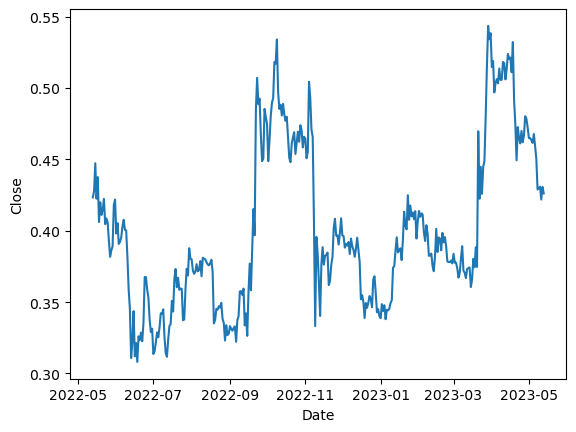

In [157]:
# Read the CSV file
df = pd.read_csv("XRP-USD.csv", parse_dates = ['Date'], index_col = ['Date'])
df.index.freq = 'D'
# Convert the Date column to a datetime object
#df['Date'] = pd.to_datetime(df['Date'])
df_test = pd.read_csv("XRP-USD.csv", parse_dates = ['Date'], index_col = ['Date'], infer_datetime_format=True)
df_test.index = df_test.index.astype('int64') // 10**9


plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(df['Close'])



In [105]:
# Check for trends
def check_for_trends(df_test):
    # Calculate the slope of the line
    slope = np.polyfit(df_test.index.astype("float64"), df["Close"], 1)[0]

    # If the slope is not equal to zero, then the data has a trend
    if slope != 0:
        return False

    # Otherwise, the data does not have a trend
    return True

# Check for seasonality
def check_for_seasonality(df_test):
    # Calculate the mean of the data for each month
    monthly_means = df_test.groupby(df_test.index.month).mean()

    # If the mean of the data for each month is not equal, then the data has seasonality
    if not monthly_means.eq(monthly_means.mean()).all():
        return False

    # Otherwise, the data does not have seasonality
    return True

# Check for stationarity
def check_for_stationarity(df_test):
    # If the data has a trend or seasonality, then it is not stationary
    if not check_for_trends(df_test) or not check_for_seasonality(df_test):
        return False

    # Otherwise, the data is stationary
    return True

# Print the result
if check_for_stationarity(df_test):
    print("The data is stationary")
else:
    print("The data is not stationary")

The data is not stationary


In [101]:
df.index

DatetimeIndex(['2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16',
               '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20',
               '2022-05-21', '2022-05-22',
               ...
               '2023-05-04', '2023-05-05', '2023-05-06', '2023-05-07',
               '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
               '2023-05-12', '2023-05-13'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  366
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7693.085
Date:                            Sat, 13 May 2023   AIC                          15396.171
Time:                                    12:51:49   BIC                          15415.503
Sample:                                05-13-2022   HQIC                         15403.863
                                     - 05-13-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4518      0.157      2.882      0.004       0.145       0.759
ma.L1         -0.8392      0.093   

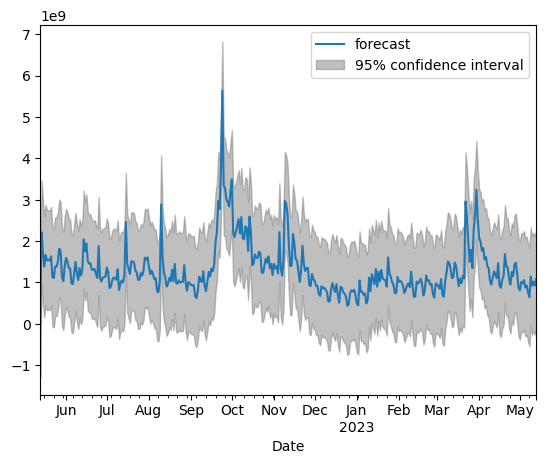

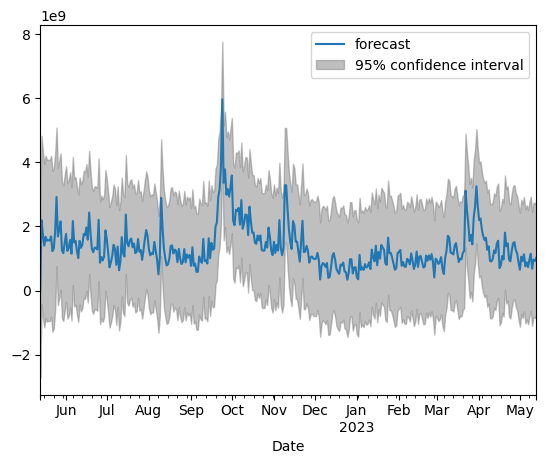

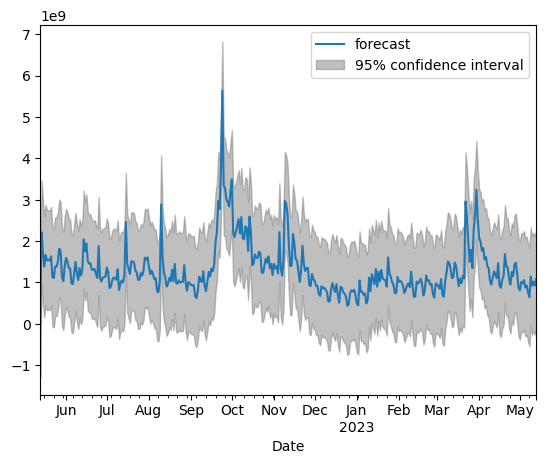

In [158]:
# Fit a SARIMA model to the Volume column
volume_sarima_model = SARIMAX(df["Volume"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
vsf_fit = volume_sarima_model.fit()

# Fit an ARIMA model to the Close column
close_arima_model = ARIMA(df["Volume"], order=(1, 1, 1))
csm_fit = close_arima_model.fit()

# Analyze the models

print(vsf_fit.summary())
print(csm_fit.summary())

# Plot the predictions
# Plot the predictions

plot_predict(vsf_fit, start=df.index[0], end=df.index[-1])
plot_predict(csm_fit, start=df.index[0], end=df.index[-1])

In [161]:
# Rescale the data
close_scaled = df["Close"] * 10

# Create the Exponential Smoothing model
close_es_model = ExponentialSmoothing(close_scaled, trend='additive', seasonal='additive', seasonal_periods=12)
expo_fit = close_es_model.fit()

# Create the GARCH model
close_garch_model = arch_model(close_scaled, p=1, q=1)
garch_fit = close_garch_model.fit()

# Make predictions for the next 10 days
close_es_predictions = expo_fit.predict(10)
close_garch_predictions = garch_fit.forecast(reindex=True)

# Print the predictions
print("Exponential Smoothing predictions:")
print(close_es_predictions / 10)

#print("GARCH predictions:")
#print(close_garch_predictions / 10)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 106077029117628.19
Iteration:      2,   Func. Count:     16,   Neg. LLF: 187039697.321418
Iteration:      3,   Func. Count:     23,   Neg. LLF: 265.9009562092009
Iteration:      4,   Func. Count:     29,   Neg. LLF: 210.7171058135848
Iteration:      5,   Func. Count:     35,   Neg. LLF: 156.45919370029986
Iteration:      6,   Func. Count:     40,   Neg. LLF: 156.61855148041874
Iteration:      7,   Func. Count:     46,   Neg. LLF: 712.2526755948696
Iteration:      8,   Func. Count:     53,   Neg. LLF: 156.412893723334
Iteration:      9,   Func. Count:     60,   Neg. LLF: 156.11873184525058
Iteration:     10,   Func. Count:     65,   Neg. LLF: 156.11799834920197
Iteration:     11,   Func. Count:     70,   Neg. LLF: 156.1170146983716
Iteration:     12,   Func. Count:     75,   Neg. LLF: 156.11584476109556
Iteration:     13,   Func. Count:     80,   Neg. LLF: 156.11551449425866
Iteration:     14,   Func. Count:     85,   Neg. LLF: 156.1

In [174]:
# Rescale the data
close_scaled = df["Close"] * 10

# Create the Exponential Smoothing model
close_es_model = ExponentialSmoothing(close_scaled, trend='additive', seasonal='additive', seasonal_periods=12)
expo_fit = close_es_model.fit()

# Make predictions for the next 10 days
close_es_predictions = expo_fit.forecast(steps=10)
close_es_predictions = close_es_predictions / 10

# Append empty rows to the end of the DataFrame for the predicted dates
pred_dates = pd.date_range(start=df.index[-1], periods=10+1, freq='D')[1:]
pred_df = pd.DataFrame(index=pred_dates, columns=df.columns)

# Concatenate the original DataFrame with the predicted DataFrame
df_extended = pd.concat([df, pred_df])

# Rescale the extended DataFrame
close_scaled_extended = df_extended["Close"] * 10

# Make predictions for the extended DataFrame
extended_predictions = expo_fit.predict(start=df_extended.index[0], end=df_extended.index[-1])
extended_predictions = extended_predictions / 10

# Print the predictions
print("Exponential Smoothing predictions:")
print(extended_predictions[-10:])




Exponential Smoothing predictions:
2023-05-14    0.430038
2023-05-15    0.430846
2023-05-16    0.431035
2023-05-17    0.431571
2023-05-18    0.427879
2023-05-19    0.424509
2023-05-20    0.428668
2023-05-21    0.427546
2023-05-22    0.427027
2023-05-23    0.427689
Freq: D, dtype: float64


In [ ]:


# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Rescale the data
close_scaled_train = train_data["Close"] * 10

# Create the Exponential Smoothing model
close_es_model = ExponentialSmoothing(close_scaled_train, trend='additive', seasonal='additive', seasonal_periods=12)
expo_fit = close_es_model.fit()

# Make predictions for the next 10 days
close_es_predictions = expo_fit.forecast(steps=10)
close_es_predictions = close_es_predictions / 10

# Print the predictions
print("Exponential Smoothing predictions:")
print(close_es_predictions)

# Calculate error metrics on the test data
close_scaled_test = test_data["Close"] * 10
test_predictions = expo_fit.predict(start=test_data.index[0], end=test_data.index[-1])
test_predictions = test_predictions / 10
mse = mean_squared_error(close_scaled_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(close_scaled_test, test_predictions)
print("Test error metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

In [223]:


# Create the GARCH model
close_garch_model = arch_model(close_scaled, p=1, q=1)
garch_fit = close_garch_model.fit()

# Make predictions for the next 10 days
forecast = garch_fit.forecast(horizon=1, reindex = True)
close_garch_predictions = forecast.mean


# Append empty rows to the end of the DataFrame for the predicted dates
pred_dates = pd.date_range(start=df.index[-1], periods=2, freq='D')[1:]
pred_df = pd.DataFrame(pred_dates, columns=[['Predicted Close']])


#Rescale the extended DataFrame
close_scaled_extended = df_extended["Close"] * 10



#Print the predictions
# print("GARCH predictions:")
# print(garch_extended_predictions)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 106077029117628.19
Iteration:      2,   Func. Count:     16,   Neg. LLF: 187039697.321418
Iteration:      3,   Func. Count:     23,   Neg. LLF: 265.9009562092009
Iteration:      4,   Func. Count:     29,   Neg. LLF: 210.7171058135848
Iteration:      5,   Func. Count:     35,   Neg. LLF: 156.45919370029986
Iteration:      6,   Func. Count:     40,   Neg. LLF: 156.61855148041874
Iteration:      7,   Func. Count:     46,   Neg. LLF: 712.2526755948696
Iteration:      8,   Func. Count:     53,   Neg. LLF: 156.412893723334
Iteration:      9,   Func. Count:     60,   Neg. LLF: 156.11873184525058
Iteration:     10,   Func. Count:     65,   Neg. LLF: 156.11799834920197
Iteration:     11,   Func. Count:     70,   Neg. LLF: 156.1170146983716
Iteration:     12,   Func. Count:     75,   Neg. LLF: 156.11584476109556
Iteration:     13,   Func. Count:     80,   Neg. LLF: 156.11551449425866
Iteration:     14,   Func. Count:     85,   Neg. LLF: 156.1

In [224]:
close_garch_predictions

,h.1
Date,
2022-05-13,NaN
2022-05-14,NaN
2022-05-15,NaN
2022-05-16,NaN
2022-05-17,NaN
...,...
2023-05-09,NaN
2023-05-10,NaN
2023-05-11,NaN
